# Movie Rating Prediction Model

## Goal
- The purpose of this notebook is to build a predictive model for movie ratings based on various features such as keywords, genres, director, and average user ratings. 
- The model predicts how a particular user will rate a movie on a scale of 0 - 5.0, given their past rating history.
- Utilizing embeddings to encode high cardinality categorical features like keywords(1932 unique keywords) to improve model performance, instead of traditional encoding methods like label-encoding or one-hot encoding which has its flaws in our context.

## Scope
- **Personalized Movie Recommendations**: The model can be extended to create a recommendation system that suggests movies to users based on their predicted ratings. 
- By identifying movies that a user is likely to rate highly, the system can provide tailored suggestions, enhancing user experience on platforms like streaming services.

## Data
- Contains movie rating data logged by me on *Letterboxd* 
- Gathered more features from tmdb api using the unique movie id.

## Sections
1. Data preprocessing
2. Model Preparation:
    - Define a neural network using embedding layers for categorical data.
3. Model Training
4. Model Evaluation
5. Predicting rating by a user from a different movie sample.



In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
from keras import layers
import random

In [6]:
# Set the random seeds for reproducibility
seed_value = 42 
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

In [7]:
print(keras.__version__)

3.5.0


In [8]:
df=pd.read_pickle("dataframe_keywords.pkl")

In [9]:
df.head(2)

,Date_logged,movie_id,Name,Year,overview,genres,keywords,actors,director,average_rating,vote_count,popularity,rating_given
0,2021-10-02,278,The Shawshank Redemption,1994,Imprisoned in the 1940s for the double murder ...,"Drama, Crime","prison, friendship, police brutality, corrupti...","Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Frank Darabont,8.706,26839,150.307,5.0
1,2021-10-02,489,Good Will Hunting,1997,When professors discover that an aimless janit...,Drama,"boston, massachusetts, professor, baseball, ma...","Matt Damon, Robin Williams, Ben Affleck, Stell...",Gus Van Sant,8.158,12188,72.632,5.0


For our task, we will focus on the following features for training the model, as they are the most influential in determining movie ratings by a user:

- Keywords 
- Genres 
- Average rating (audience)

In [10]:
df=df[["movie_id","Name","keywords","genres","average_rating","rating_given"]]

In [11]:
df.head(2)

,movie_id,Name,keywords,genres,average_rating,rating_given
0,278,The Shawshank Redemption,"prison, friendship, police brutality, corrupti...","Drama, Crime",8.706,5.0
1,489,Good Will Hunting,"boston, massachusetts, professor, baseball, ma...",Drama,8.158,5.0


In [12]:
# Convert keywords from a string to a list (if they are stored as comma-separated strings)
df['keywords'] = df['keywords'].apply(lambda x: x.split(', '))
df['genres'] = df['genres'].apply(lambda x: x.split(', '))

In [13]:
df.head(2)

,movie_id,Name,keywords,genres,average_rating,rating_given
0,278,The Shawshank Redemption,"[prison, friendship, police brutality, corrupt...","[Drama, Crime]",8.706,5.0
1,489,Good Will Hunting,"[boston, massachusetts, professor, baseball, m...",[Drama],8.158,5.0


In [14]:
from sklearn.preprocessing import LabelEncoder

# Flatten the list of all keywords and genres across the dataset
all_keywords = [keyword for keywords_list in df['keywords'] for keyword in keywords_list]
all_genres = [genre for genre_list in df['genres'] for genre in genre_list]

# Create separate LabelEncoders for keywords and genres
le_keywords = LabelEncoder()
le_genres = LabelEncoder()

# Fit the LabelEncoders on the unique keywords and genres
le_keywords.fit(all_keywords)
le_genres.fit(all_genres)


# Now encode each keyword list and genre list into integer IDs
df['keywords_encoded'] = df['keywords'].apply(lambda keywords: le_keywords.transform(keywords))
df['genres_encoded'] = df['genres'].apply(lambda genres: le_genres.transform(genres))


In [15]:
df.tail(5)

,movie_id,Name,keywords,genres,average_rating,rating_given,keywords_encoded,genres_encoded
207,840430,The Holdovers,"[vietnam war, winter, boarding school, holiday...","[Comedy, Drama]",7.714,4.5,"[1838, 1892, 228, 833, 236, 1057, 11, 38, 52, ...","[3, 6]"
208,1581,The Holiday,"[london, england, movie business, christmas pa...","[Comedy, Romance]",7.093,2.5,"[987, 577, 1138, 344, 409, 1821, 1673, 991, 27...","[3, 13]"
209,6977,No Country for Old Men,"[vietnam veteran, sheriff, trailer park, based...","[Crime, Drama, Thriller]",7.945,4.0,"[1837, 1533, 1770, 172, 830, 1352, 540, 1730, ...","[4, 6, 15]"
210,792307,Poor Things,"[ship, london, england, experiment, paris, fra...","[Science Fiction, Romance, Comedy]",7.763,4.0,"[1539, 987, 577, 605, 1250, 704, 172, 1205, 98...","[14, 13, 3]"
211,693134,Dune: Part Two,"[epic, based on novel or book, fight, politics...","[Science Fiction, Adventure]",8.165,5.0,"[581, 172, 669, 1303, 1455, 1453, 1605, 342, 4...","[14, 1]"


In [16]:
from keras_preprocessing.sequence import pad_sequences

MAX_KEYWORDS = 20
MAX_GENRES = 3

# Pad the sequences (post-padding will add zeros after shorter sequences)
X_keywords_padded = np.array(pad_sequences(df['keywords_encoded'], maxlen=MAX_KEYWORDS, padding='post'))
X_genres_padded = np.array(pad_sequences(df['genres_encoded'], maxlen=MAX_GENRES, padding='post'))


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212 entries, 0 to 211
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   movie_id          212 non-null    int64  
 1   Name              212 non-null    object 
 2   keywords          212 non-null    object 
 3   genres            212 non-null    object 
 4   average_rating    212 non-null    float64
 5   rating_given      212 non-null    float64
 6   keywords_encoded  212 non-null    object 
 7   genres_encoded    212 non-null    object 
dtypes: float64(2), int64(1), object(5)
memory usage: 14.9+ KB


In [18]:
df.explode("keywords")["keywords"].nunique()

1932

In [19]:
from sklearn.metrics import mean_absolute_error

y_rating = np.array(df['rating_given'], dtype=np.float32)

# Step 1: Define the model
# Input for keywords
keyword_input = keras.Input(shape=(20,), name='keywords_input')  # Shape matches padded keywords
keywords_embedded = keras.layers.Embedding(input_dim=1932, output_dim=16, input_length=20)(keyword_input)

# Input for genres
genre_input = keras.Input(shape=(3,), name='genres_input')  # Shape matches padded genres
genres_embedded = keras.layers.Embedding(input_dim=18, output_dim=16, input_length=3)(genre_input)


# Flatten both embeddings
keywords_flattened = keras.layers.Flatten()(keywords_embedded)
genres_flattened = keras.layers.Flatten()(genres_embedded)

# Input for average_rating (numerical feature)
avg_rating_input = keras.Input(shape=(1,), name='avg_rating_input')

# Concatenate embeddings from keywords and genres
combined = keras.layers.Concatenate()([keywords_flattened, genres_flattened, avg_rating_input])

# Add a Dense layer after concatenation
out = keras.layers.Dense(32, activation='relu')(combined)
out = keras.layers.Dense(16, activation='relu')(out)

# Add hidden layers (using loop for flexibility)
hidden_units = (32, 16)
for n_hidden in hidden_units:
    out = keras.layers.Dense(n_hidden, activation='relu')(out)

# Output layer: predicted rating
output = keras.layers.Dense(1, activation='linear', name='prediction')(out)

c:\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [20]:
model = keras.Model(inputs=[keyword_input,genre_input,avg_rating_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error'])

In [21]:
# Check the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keywords_input      │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genres_input        │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 20, 16)    │     30,912 │ keywords_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 3, 16)     │        288 │ genres_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 320)       │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 48)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ avg_rating_input    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 369)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ avg_rating_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │     11,840 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │        544 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │        528 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prediction (Dense)  │ (None, 1)         │         17 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 44,657 (174.44 KB)

 Trainable params: 44,657 (174.44 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Step 2: Split the dataset into training and validation sets
from sklearn.model_selection import train_test_split

# Assuming df contains the entire dataset (movies and ratings)
df_train, df_val = train_test_split(df, test_size=0.1, random_state=seed_value)  # 90% train, 10% validation

# Prepare validation data (use the same padding and conversion as for the training set)
X_val_keywords_padded = pad_sequences(df_val['keywords_encoded'], maxlen=MAX_KEYWORDS, padding='post', truncating='post')
X_val_genres_padded = pad_sequences(df_val['genres_encoded'], maxlen=MAX_GENRES, padding='post', truncating='post')

X_val_avg_rating = np.array(df_val['average_rating'], dtype=np.int32)

X_avg_rating= np.array(df['average_rating'], dtype=np.int32)
y_val_rating = np.array(df_val['rating_given'], dtype=np.float32)


In [23]:
# Step 3: Train the model
history = model.fit(
    [X_keywords_padded, X_genres_padded,X_avg_rating],  
    y_rating,                              # Target: rating_given
    batch_size=8,                          # Batch size (small dataset, so small batch size)
    epochs=30,                             # Number of epochs
    verbose=1,                             # Show training progress
    validation_data=([X_val_keywords_padded, X_val_genres_padded,X_val_avg_rating], y_val_rating)  # Validation data
)


Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 9.8417 - mean_absolute_error: 3.0258 - val_loss: 1.3113 - val_mean_absolute_error: 0.9620
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8749 - mean_absolute_error: 0.7552 - val_loss: 0.3007 - val_mean_absolute_error: 0.4589
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3570 - mean_absolute_error: 0.4809 - val_loss: 0.1891 - val_mean_absolute_error: 0.3449
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2494 - mean_absolute_error: 0.3880 - val_loss: 0.1204 - val_mean_absolute_error: 0.2639
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1753 - mean_absolute_error: 0.3169 - val_loss: 0.0820 - val_mean_absolute_error: 0.2051
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1071 - mean_absolute_error: 0.2407 - val_loss: 0.0618 - val_mean_absolute_error: 0.1656
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0552 - mean_absolute_error: 0.1607 - val_loss: 0

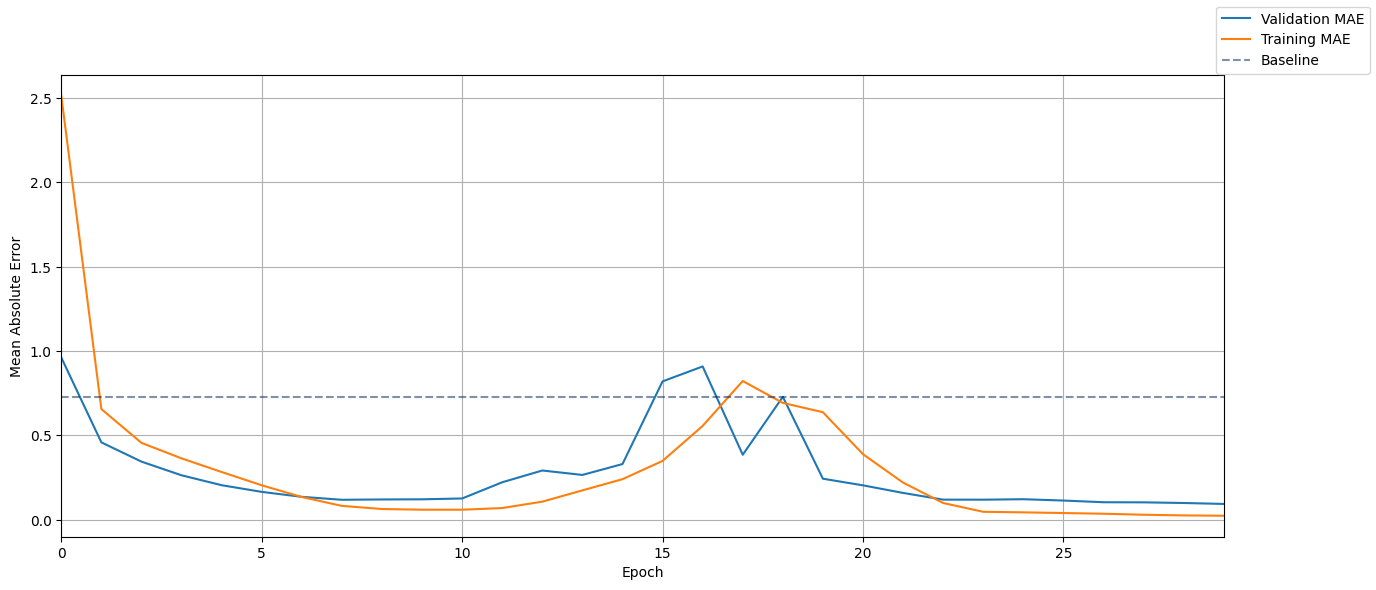

In [24]:
import matplotlib.pyplot as plt

# Step 4: Visualize training and validation MAE
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(history.epoch, history.history['val_mean_absolute_error'], label='Validation MAE')
ax.plot(history.epoch, history.history['mean_absolute_error'], label='Training MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlim(left=0, right=history.epoch[-1])
baseline_mae = 0.73  # Baseline MAE (replace with the actual baseline you calculated)
ax.axhline(baseline_mae, ls='--', label='Baseline', color='#002255', alpha=0.5)
ax.grid()
fig.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
R² score for validation set: 0.9106921390879748


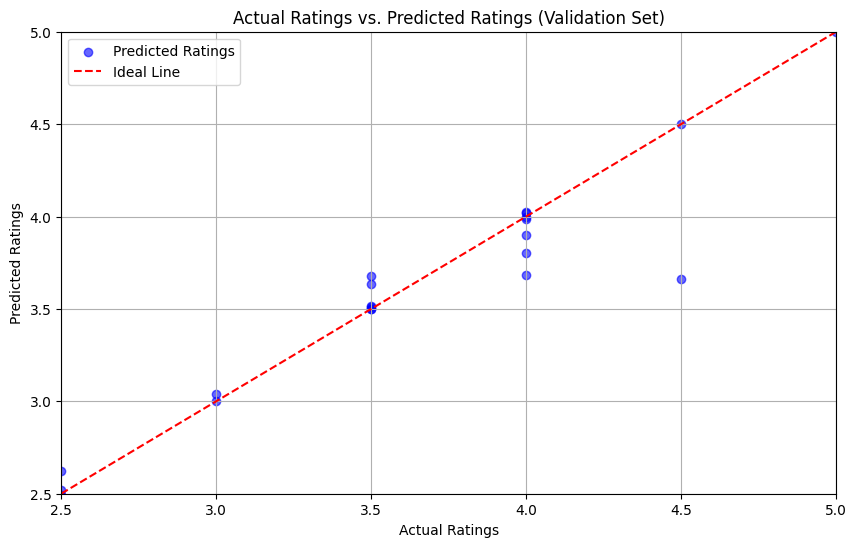

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


# Predict ratings for the validation set
y_val_pred = (model.predict([X_val_keywords_padded,X_val_genres_padded,X_val_avg_rating]))

# Calculate R² score for validation
r2_val = r2_score(y_val_rating, y_val_pred)
print(f'R² score for validation set: {r2_val}')

# Create the scatter plot for validation data
plt.figure(figsize=(10, 6))
plt.scatter(y_val_rating, y_val_pred, color='blue', alpha=0.6, label='Predicted Ratings')
plt.plot([y_val_rating.min(), y_val_rating.max()], 
         [y_val_rating.min(), y_val_rating.max()], 
         color='red', linestyle='--', label='Ideal Line')  # Ideal line
plt.title('Actual Ratings vs. Predicted Ratings (Validation Set)')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.xlim(y_val_rating.min(), y_val_rating.max())
plt.ylim(y_val_rating.min(), y_val_rating.max())
plt.grid()
plt.legend()  
plt.show()


**Model Evaluation**:
- *r2 score* = 0.91
- *mae* = 0.09

 Our model looks pretty decent. Most of the predictions are very near to the actual rating.

### Checking movies with a rating difference over 0.5

In [67]:
# Flatten y_val_pred to make it 1-dimensional
y_val_pred_flat = y_val_pred.ravel()  # or y_val_pred[:, 0]

# Create a DataFrame with actual and predicted ratings side by side
df_results = pd.DataFrame({
    'Actual Rating': y_val_rating,
    'Predicted Rating': y_val_pred_flat  # Use the flattened array
})

# Display rows with significant error in prediction
high_diff=df_results[abs(df_results["Actual Rating"]-df_results["Predicted Rating"])>0.5]


(df_val.reset_index(drop=True)
 .merge(high_diff,left_index=True,right_index=True)
 [["Name","Actual Rating","Predicted Rating"]])

,Name,Actual Rating,Predicted Rating
13,Dune,4.5,3.662421


Our model's prediction says i shouldnt have liked Dune as much as i did. But Denis Villenueve outclassed our model, lol!

Justifying this prediction:
- The essence of Dune is rooted in cinematography, editing and it just has a different vibe? 
this is something which is not translated in our feature variables.
- so it may be fair to say this might be the reason our model predicted a lower rating than the actual rating given by me.

- bit of stretch maybe, but hey, we gotta infer what we gotta infer, right?

In [65]:
# # Step 6: Save the model
# model.save('final_model.keras')

# Step 7: Load the model
# # from keras.models import load_model
# # loaded_model = load_model('movie_rating_model.h5')


In [66]:
# model.save_weights('final_model.weights.h5')


let's fetch movie details from tmdb api for predictions!

In [27]:
genres_ids=pd.read_pickle("genres.pkl") 

In [55]:
import requests
import numpy as np
from keras_preprocessing.sequence import pad_sequences

# Dictionary for genre ID to name mapping
id_to_name = {genre['id']: genre['name'] for genre in genres_ids['genres']}

# Function to fetch details (keywords, genres, avg_rating) using the movie name
def fetch_details(movie_name):
    movie_url = f"https://api.themoviedb.org/3/search/movie?query={movie_name}&include_adult=false&language=en-US&page=1"
    headers = {
    "accept": "application/json",
    "Authorization": "YOUR_TMDB_API_HERE"
    }

    response = requests.get(movie_url, headers=headers).json()["results"][0]
    movie_id = response["id"]
    title=response["title"]
    date=response["release_date"][:4]
    avg_rating = response["vote_average"]
    genre_ids = response["genre_ids"]
    genres = [id_to_name[genre_id] for genre_id in genre_ids]

    # Get keywords
    keyword_url = f"https://api.themoviedb.org/3/movie/{movie_id}/keywords"
    keyword_response = requests.get(keyword_url, headers=headers).json()["keywords"]
    keywords = [key["name"] for key in keyword_response]

    return keywords, genres, avg_rating, movie_id,title,date

# Function to encode the inputs and prepare for the model
def prepare_input(keywords, genres, avg_rating, max_keywords_length, max_genres_length, keyword_encoder, genre_encoder):
    
    # Encode keywords with handling for unseen labels
    encoded_keywords = []
    for kw in keywords:
        try:
            encoded_keywords.append(keyword_encoder.transform([kw])[0])  # Transform each keyword
        except ValueError:
            encoded_keywords.append(-1)  # Assign -1 for unseen labels
    
    # Pad the keywords to the max length
    padded_keywords = pad_sequences([encoded_keywords], maxlen=max_keywords_length, padding='post')
    
    # Encode genres with handling for unseen labels
    encoded_genres = []
    for genre in genres:
        try:
            encoded_genres.append(genre_encoder.transform([genre])[0])  # Transform each genre
        except ValueError:
            encoded_genres.append(-1)  # Assign -1 for unseen labels
    
    # Pad the genres to the max length
    padded_genres = pad_sequences([encoded_genres], maxlen=max_genres_length, padding='post')

    avg_rating_input = np.array([avg_rating])  
    
    return padded_keywords, padded_genres, avg_rating_input

I mostly logged english movies, so to check if our model is well generalized, let's predict a movie from a different sample than we've trained on (a *bollywood* movie)

### predicting the rating user(me, in this case) would give by taking *movie title* as input

In [64]:
# Step 1: Define the movie name
movie_name = "andhadhun"  # Replace with your desired movie name

# Step 2: Fetch details using the movie name
keywords, genres, avg_rating, movie_id,title,date = fetch_details(movie_name)

# Step 3: Prepare input for the model
max_keywords_length = 20  # Example max length for keywords
max_genres_length = 3     # Example max length for genres

# Assume you have trained encoders for keywords and genres
padded_keywords, padded_genres, avg_rating_input = prepare_input(
    keywords, genres, avg_rating, max_keywords_length, max_genres_length, 
    keyword_encoder=le_keywords, genre_encoder=le_genres)

# Step 4: Make the prediction using the model
predicted_rating = model.predict([padded_keywords, padded_genres, avg_rating_input])

# Print the predicted rating
print(f"Predicted rating for '{title}',{date} (Movie ID: {movie_id}): {np.ceil(predicted_rating[0][0] * 2) / 2:.2f}") #taking the ceil since we can only rate in .5 multiples


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted rating for 'Andhadhun',2018 (Movie ID: 534780): 4.50


yeppp 4.5 is exactly the rating i'd give to Andhadhun!(I have a good take on movies, don't i lol?)

our prediction model works, phew!